# Lecture 14

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rcParams
rcParams['animation.html'] = 'jshtml'
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4
import time
import os
import glob

## AOM 3.15 Exercise 9: Convective Entrainment

Convection due to surface cooling causes vigorous mixing in the upper part of an otherwise stratified fluid column.

Convective plumes mix deeper water into this layer -- this is called *entrainment*.

(100.0, 0.0)

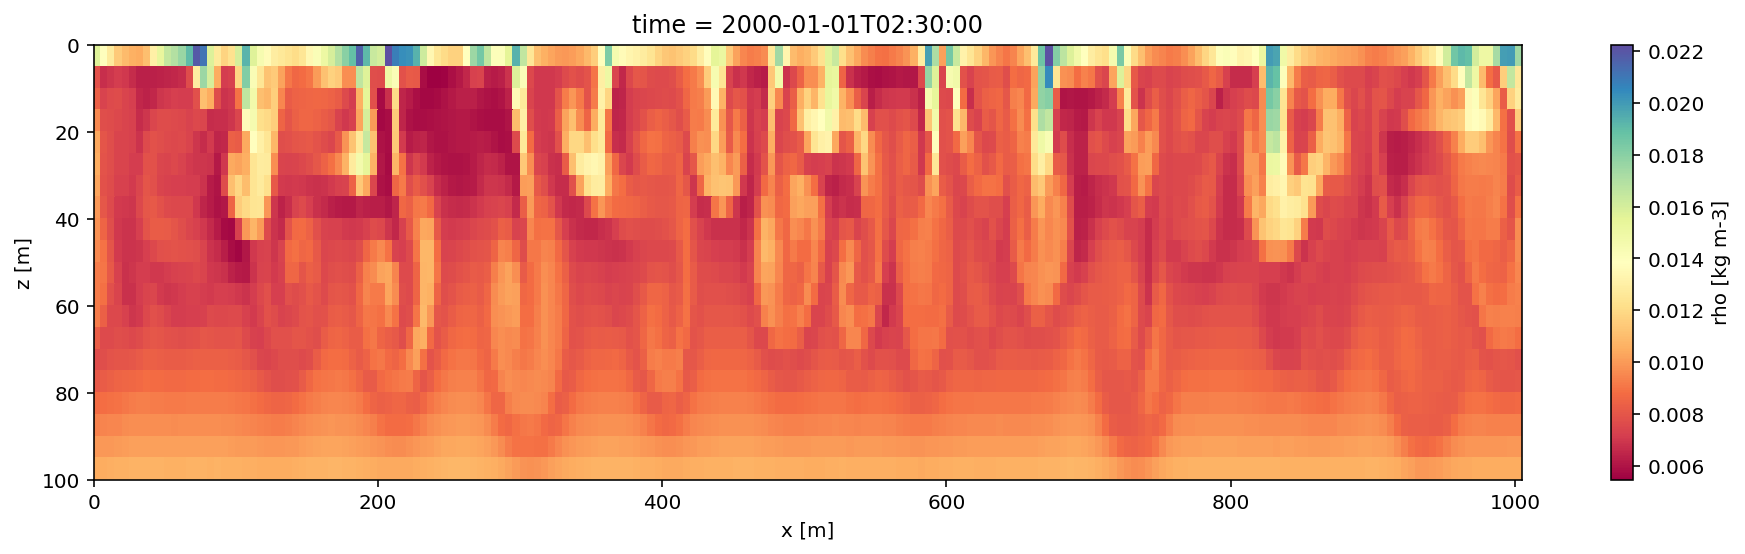

In [22]:
filename = 'src/AOM_Ex9/output.nc'
ds = xr.open_dataset(filename)
fig, ax = plt.subplots(figsize=(16, 4))
ds.rho[50].plot(ax=ax, x='x', cmap='Spectral')

plt.ylim(100, 0)

We can visualize this process using an Eulerian tracer.

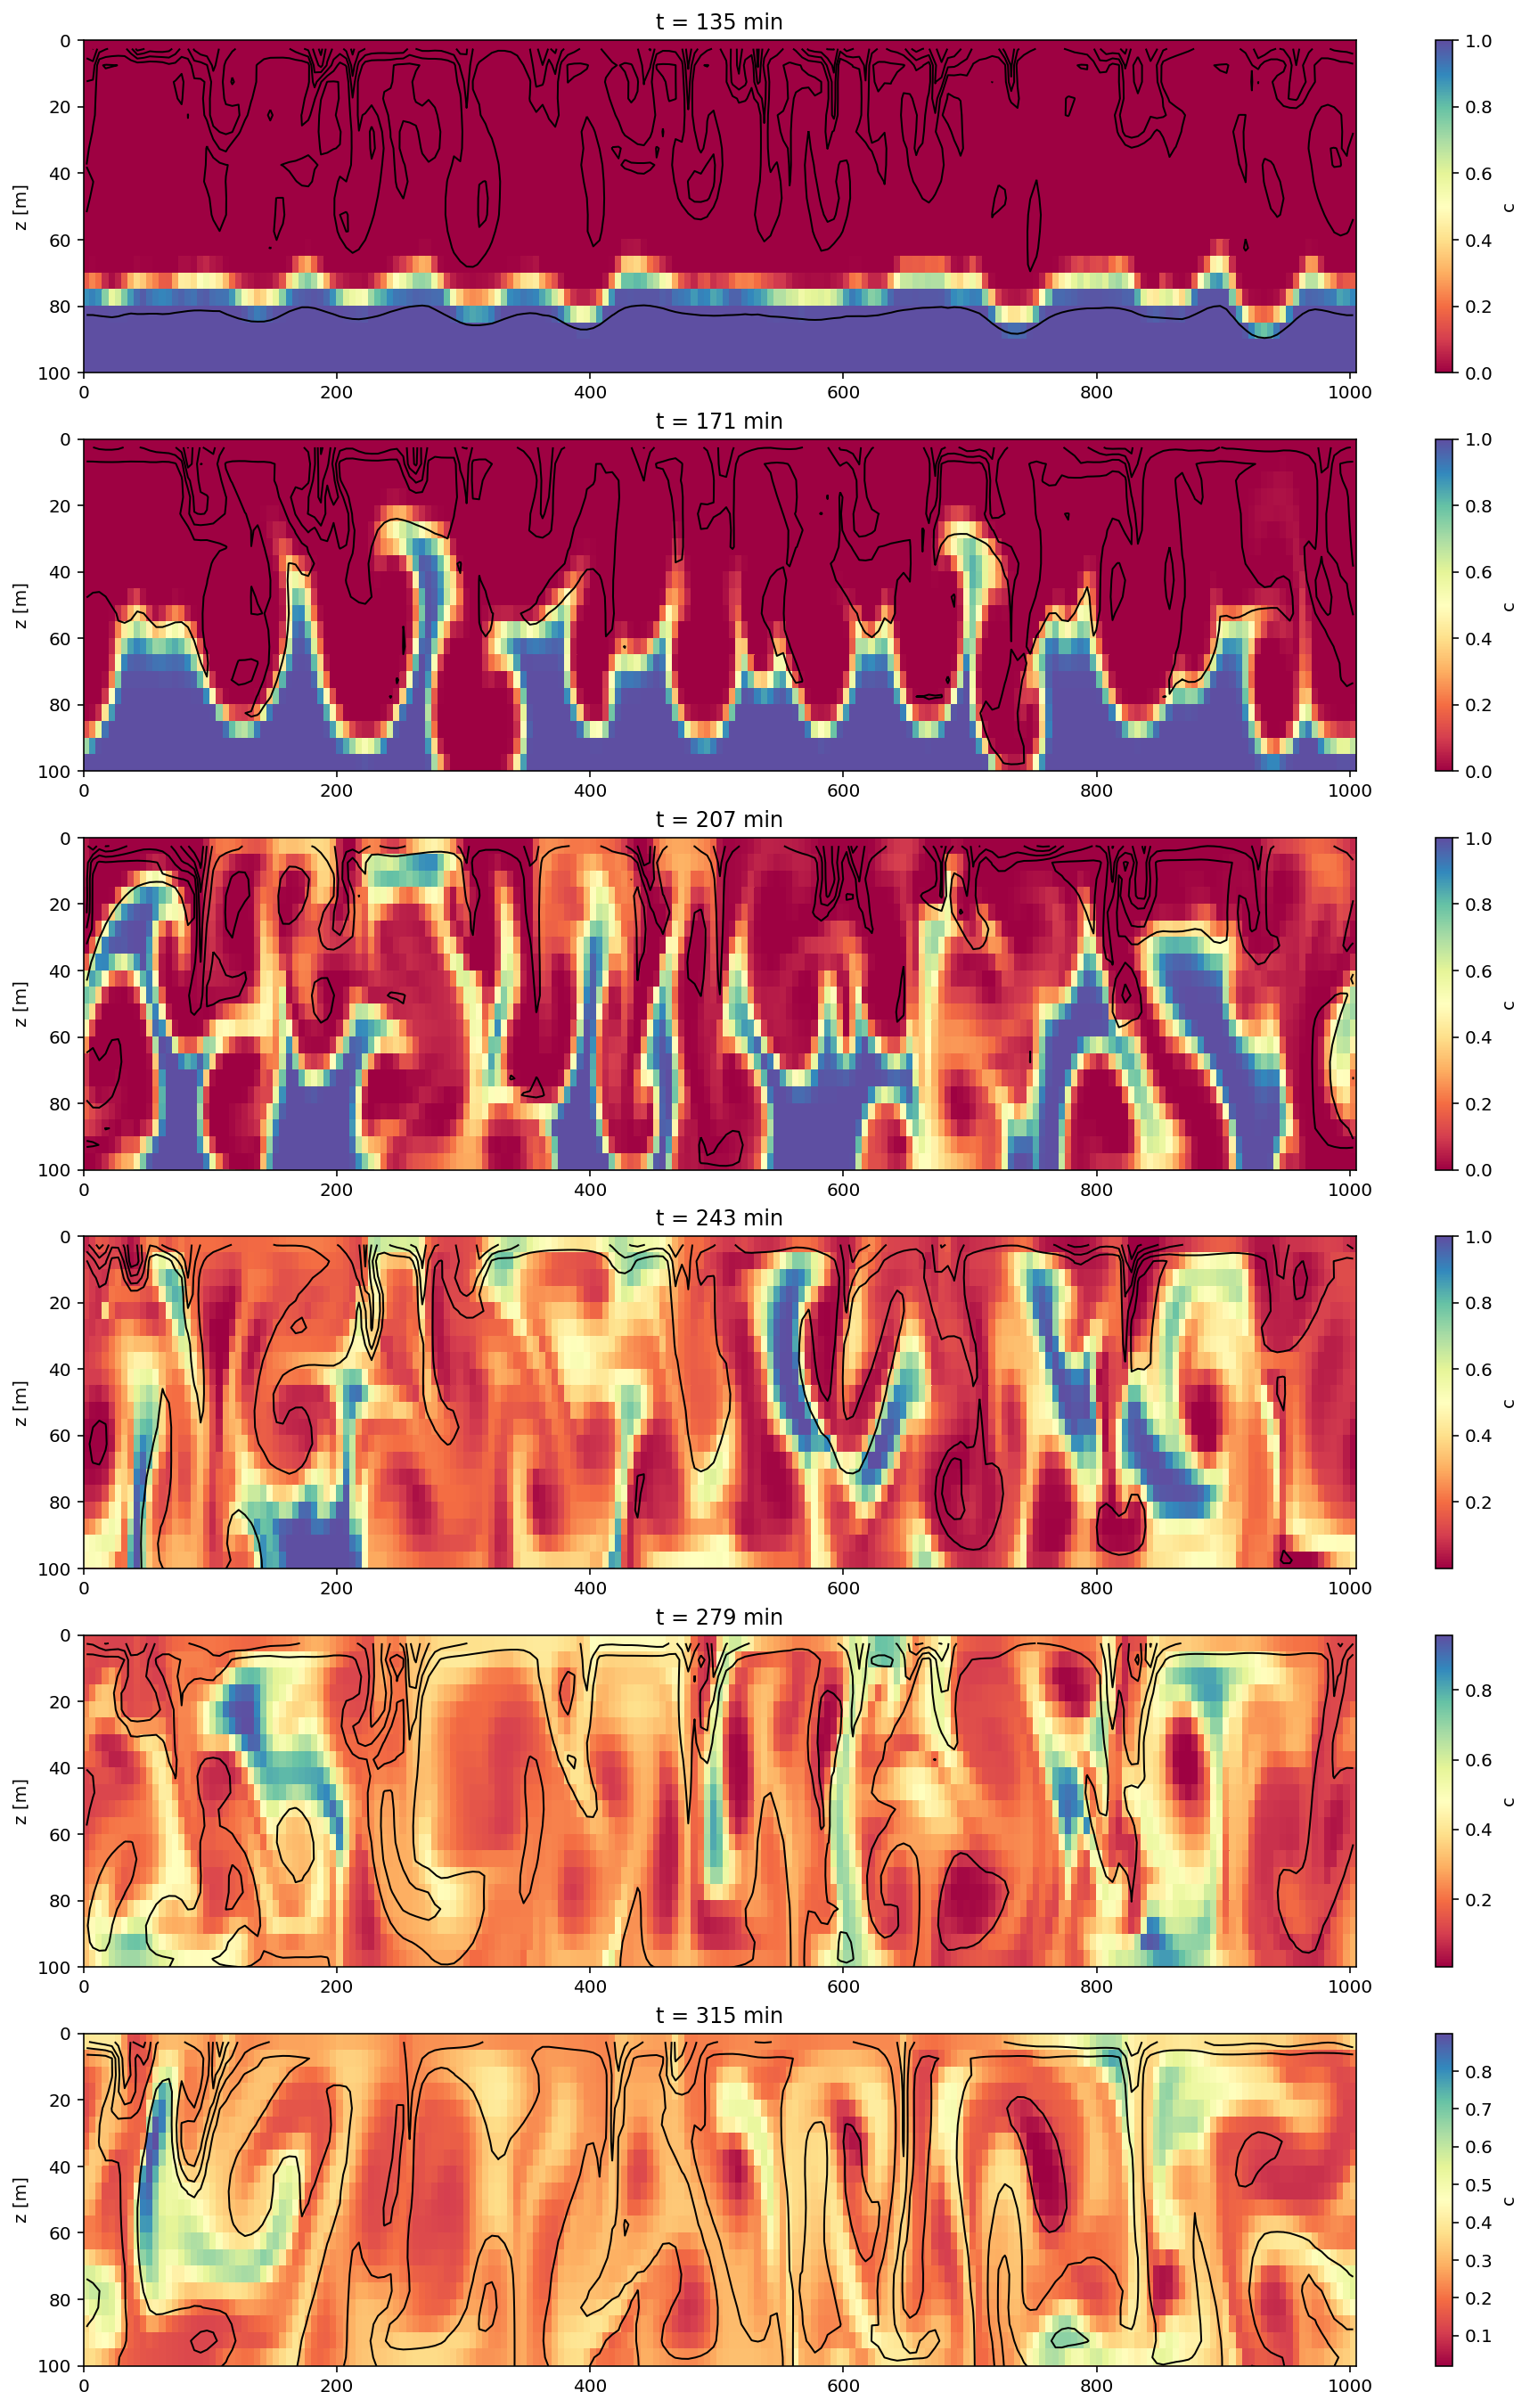

In [44]:

filename = 'src/AOM_Ex9/output.nc'
ds = xr.open_dataset(filename)

n = 6
fig, axes = plt.subplots(n, 1, figsize=(16, 24))
t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'm')

for i in range(n):
    p = 12*i + 45
    ds.c[p].plot(ax=axes[i], x='x', cmap='Spectral')
    ds.rho[p].plot.contour(ax=axes[i], x='x', colors='black', linewidths=1, add_colorbar=False)

    axes[i].set_title(f't = {t[p]:.0f} min')
    axes[i].set_xlabel('')
    axes[i].set_ylim(100, 0)


Alternatively, we can seed the lower water column with Lagrangian tracers.

In [10]:
TRx = np.loadtxt('src/AOM_Ex9/TRx.dat')
TRz = np.loadtxt('src/AOM_Ex9/TRz.dat')

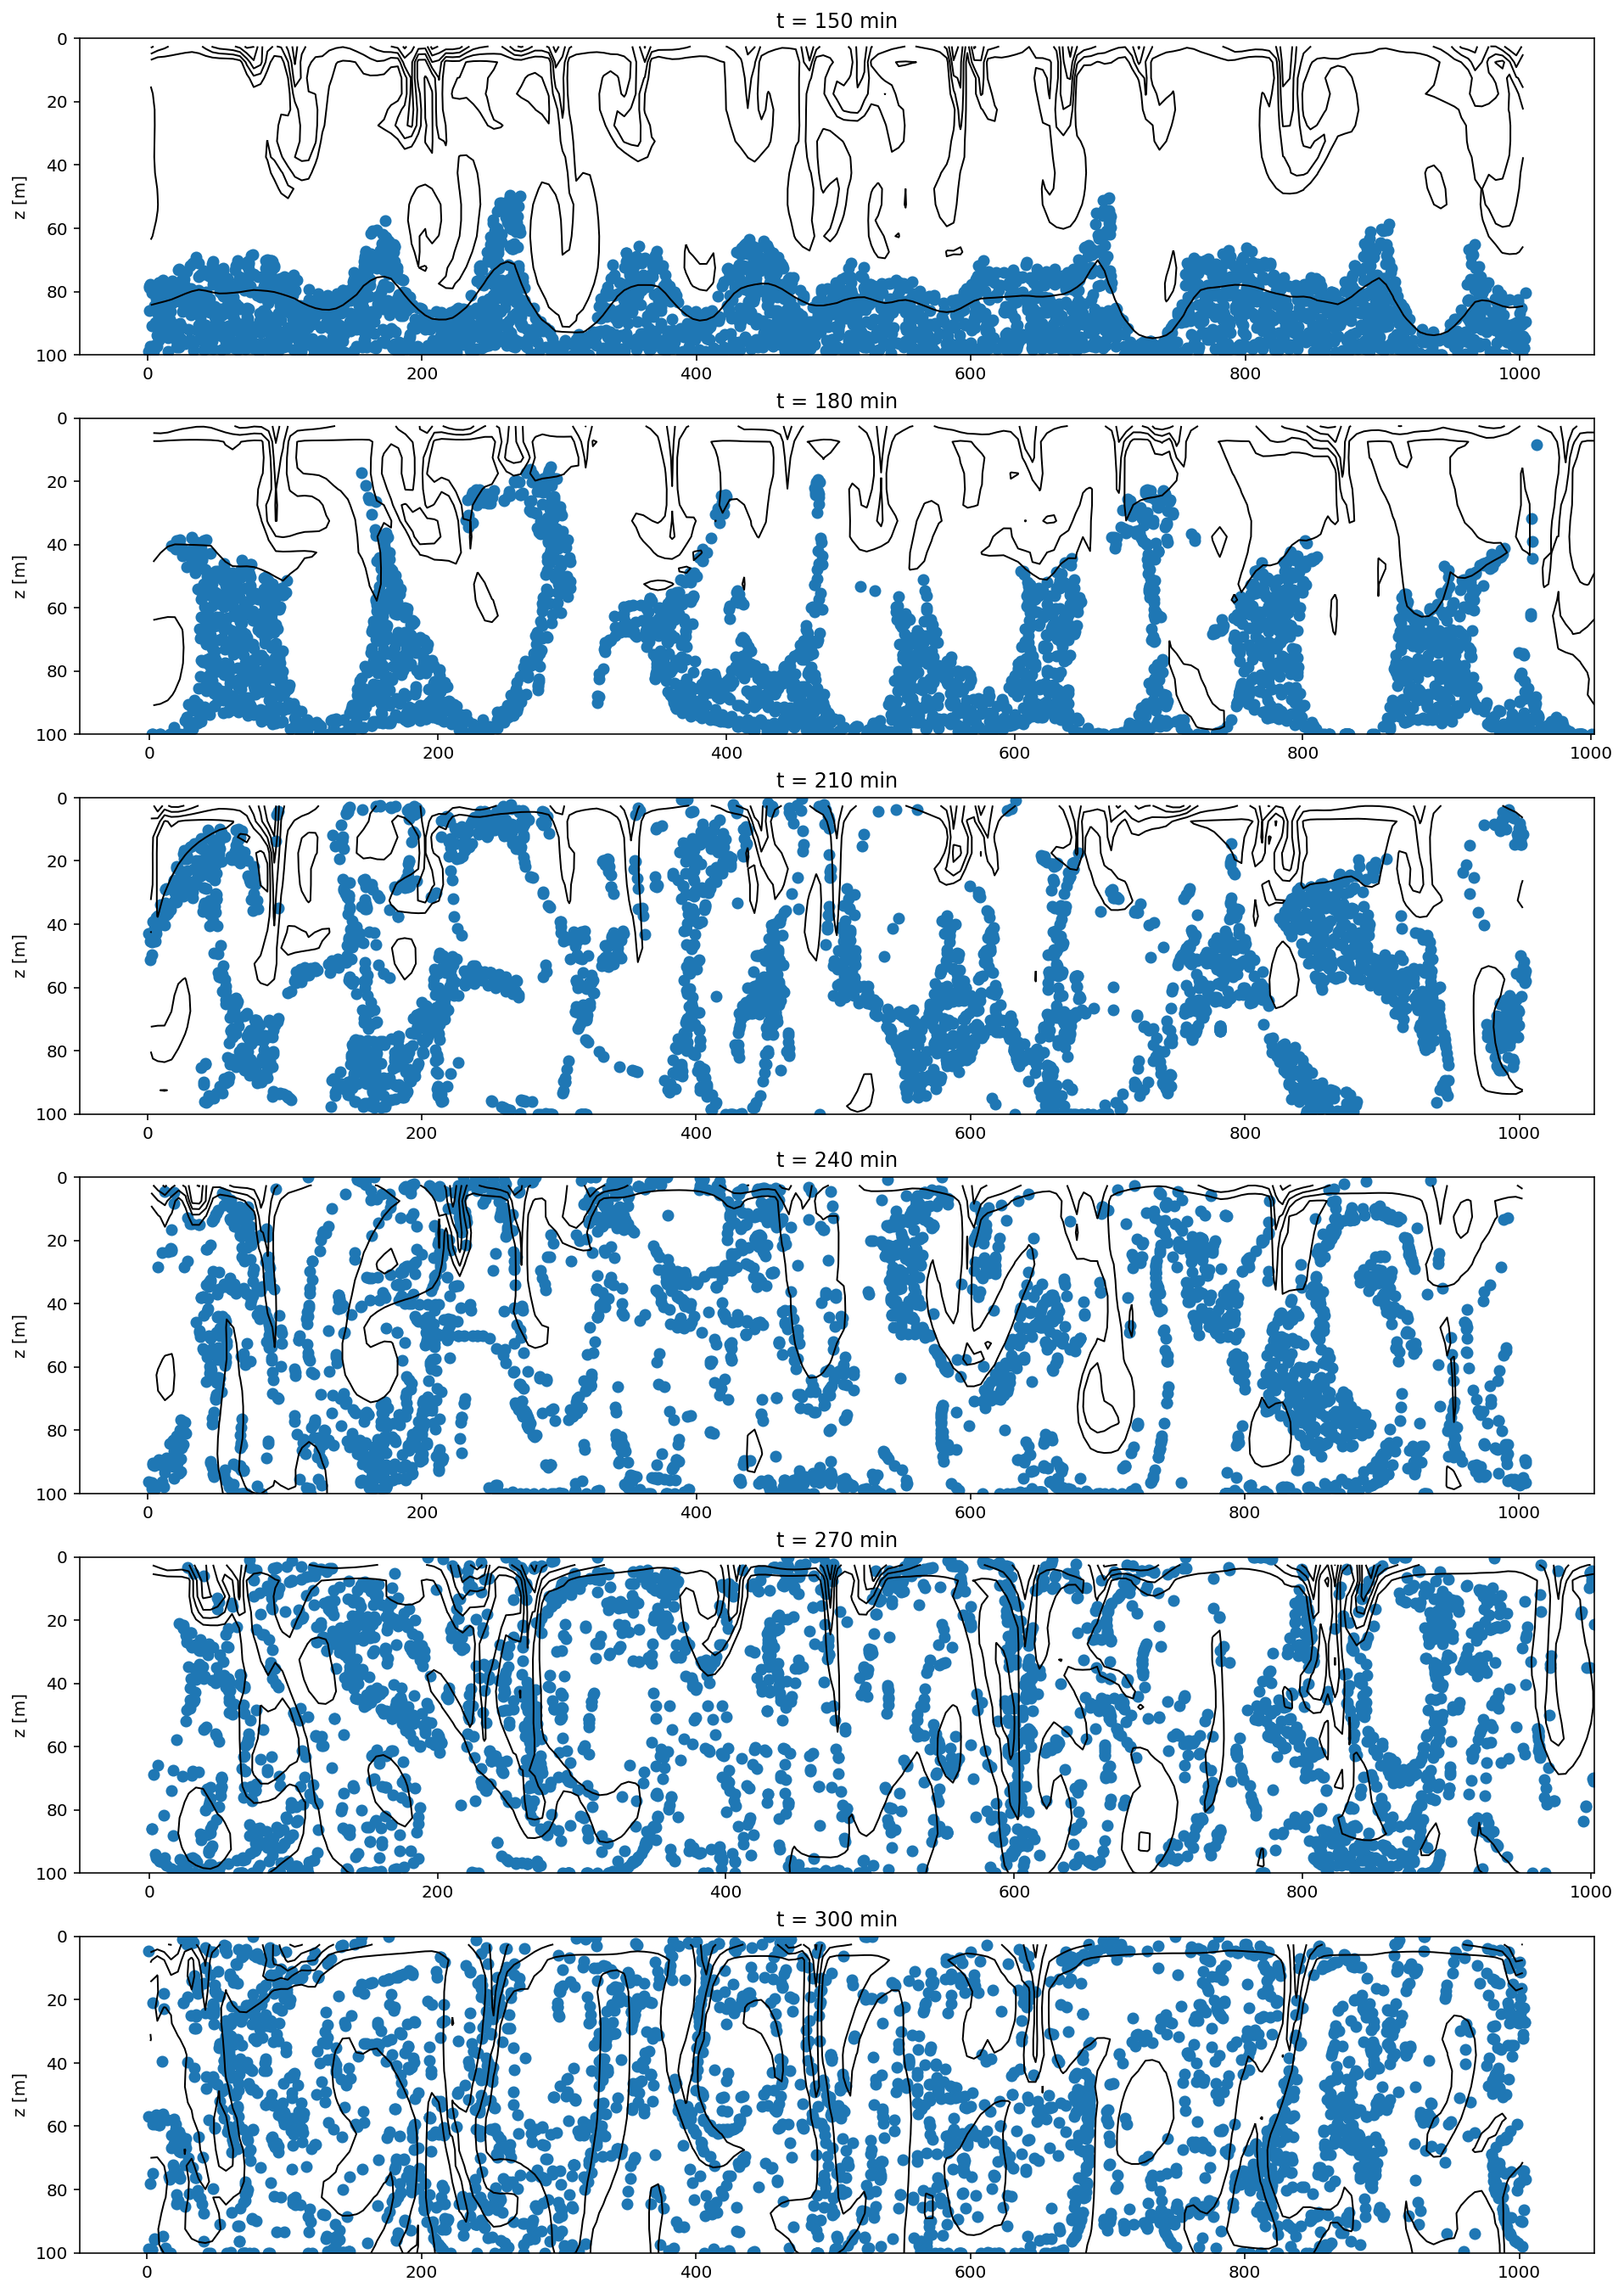

In [47]:
filename = 'src/AOM_Ex9/output.nc'
ds = xr.open_dataset(filename)

n = 6
fig, axes = plt.subplots(n, 1, figsize=(16, 24))
t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'm')

for i in range(n):
    p = 10*i + 50
    ds.rho[p].plot.contour(ax=axes[i], x='x', colors='black', linewidths=1, add_colorbar=False)
    axes[i].scatter(TRx[p], TRz[p])
    axes[i].set_title(f't = {t[p]:.0f} min')
    axes[i].set_xlabel('')
    axes[i].set_ylim(100, 0)

## AOM 3.17 Exercise 10: Slope Convection near the Shore

### 3.17.1 Background
> Under the same heat loss, a smaller volume of fluid cools down at a faster rate than
a larger volume. Therefore, we expect that convection produces the densest water
in the shallowest regions of a coastal ocean. In the presence of variable bathymetry,
a uniform surface buoyancy flux will consequently create lateral density gradients
and, hence, lateral pressure gradients in the ocean. A buoyancy-driven exchange circulation between shallow and deeper portions of the ocean follows. The aim of
this exercise is to simulate this density-driven overturning circulation using the non-hydrostatic convection model in a domain of variable bathymetry.

(100.0, 0.0)

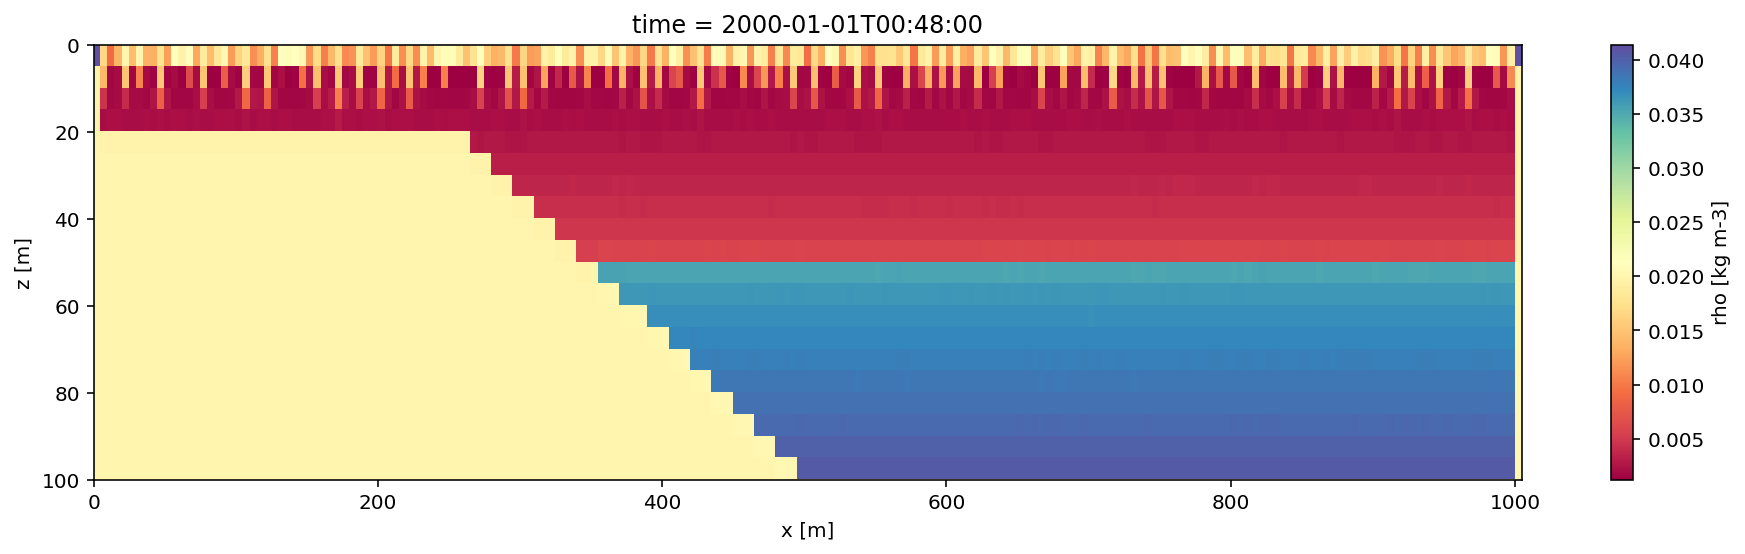

In [51]:
filename = 'src/AOM_Ex10/output.nc'
ds = xr.open_dataset(filename)
fig, ax = plt.subplots(figsize=(16, 4))
ds.rho[8].plot(ax=ax, x='x', cmap='Spectral')

plt.ylim(100, 0)

Cooling is applied only for the first six hours. Entrainment mixes and cools the fluid in the shallow region.  

> **Problem 21**: Intrusive plume
> 
> - Reproduce Figure AOM 3.39. Notice that there is a plume that intrudes into the fluid along the density interface around $z= -50$ m.  
> - Extend the simulation time of this exercise to 24 hrs and apply the surface heat
flux over the initial 12 hrs. How deep does
the resultant dense water flow penetrate into the ambient water column? 
> - Make a visualization of Lagrangian tracers to track the movement of the density-driven plume.


#### Artifacts due to bathymetry

> It should be noted that bottom-arrested flows on a step-structured sea floor
of z-coordinate models are substantially biased because their zigzag pathway is
much longer than that of real bottom-parallel flows. Another artifact is that, while
descending on the bathymetric stairs, the head of a plume has to spread laterally first
before it can sink to the next deeper level. This induces transient unstable density
stratification, which in reality does not exist, that may bias the dynamics via artificial
convective adjustments.

## AOM 3.21 Tilted Coordinate Systems

### 3.21.1 The Governing Equations

One way to address the 'staircase' bathymetry in the previous exercise is to rotate the domain so that the slope is aligned with the numerical grid. See Figure AOM 3.47.

The rotated vertical axis $z_r$ differs from the local vertical and therfore from the orientation due to gravity.  So, there is a gravity force now in both the horizontal and vertical momentum equations. See equations 3.78 -- 3.81. 

The addition of this reduced-gravity force in the horizontal momentum equation is sometimes referred to as the *buoyant-slope effect*.  If the buoyant-slope effect is balanced by a linear bottom-friction, we get

$$ \sin (\gamma) \frac{\rho'}{\rho_0} g - r u_r = 0$$

for a linear bottom-drag coefficient $r$.  This gives an equlibrium flow speed of $ u_r = \sin(\gamma) g' / r$.

## AOM 3.22 Exercise 13: Stratified Flows on a Slope

### 3.22.1 Aim
The aim of this exercise is to employ a tilted Cartesian coordinate system to simulate
the dynamics and instability of a stratified flow on a sea floor of uniform slope.

### 3.22.2 Task Description
Consider a tilted model domain, 500 m in length and 100 m in thickness, resolved
by grid spacings of Δx = 5 m and Δz = 2 m (Fig. 3.48). The sea floor has a bottom
inclination of 5$^\circ$. Lateral boundaries are cyclic. The ocean is initially at rest.
The simulation is started with prescription of a 20-m thick near-bottom layer of a
density of 1,028.2 km/m$^3$. The ambient ocean has a density of 1,028.0 km/m$^3$. Small
random noise is added to this density field. Eddy diffusivities and viscosities are set
to a uniform value of 10$^{-2}$ m$^2$/s. The bottom-drag coefficient is set to $r = 0.001$. The
total simulation time is 2 hrs with data outputs at 1-min intervals. The time step is
set to Δt = 1 s. The pressure accuracy for the S.O.R. iteration is set to $\epsilon = 0.001$ Pa.

### 3.22.3 Results

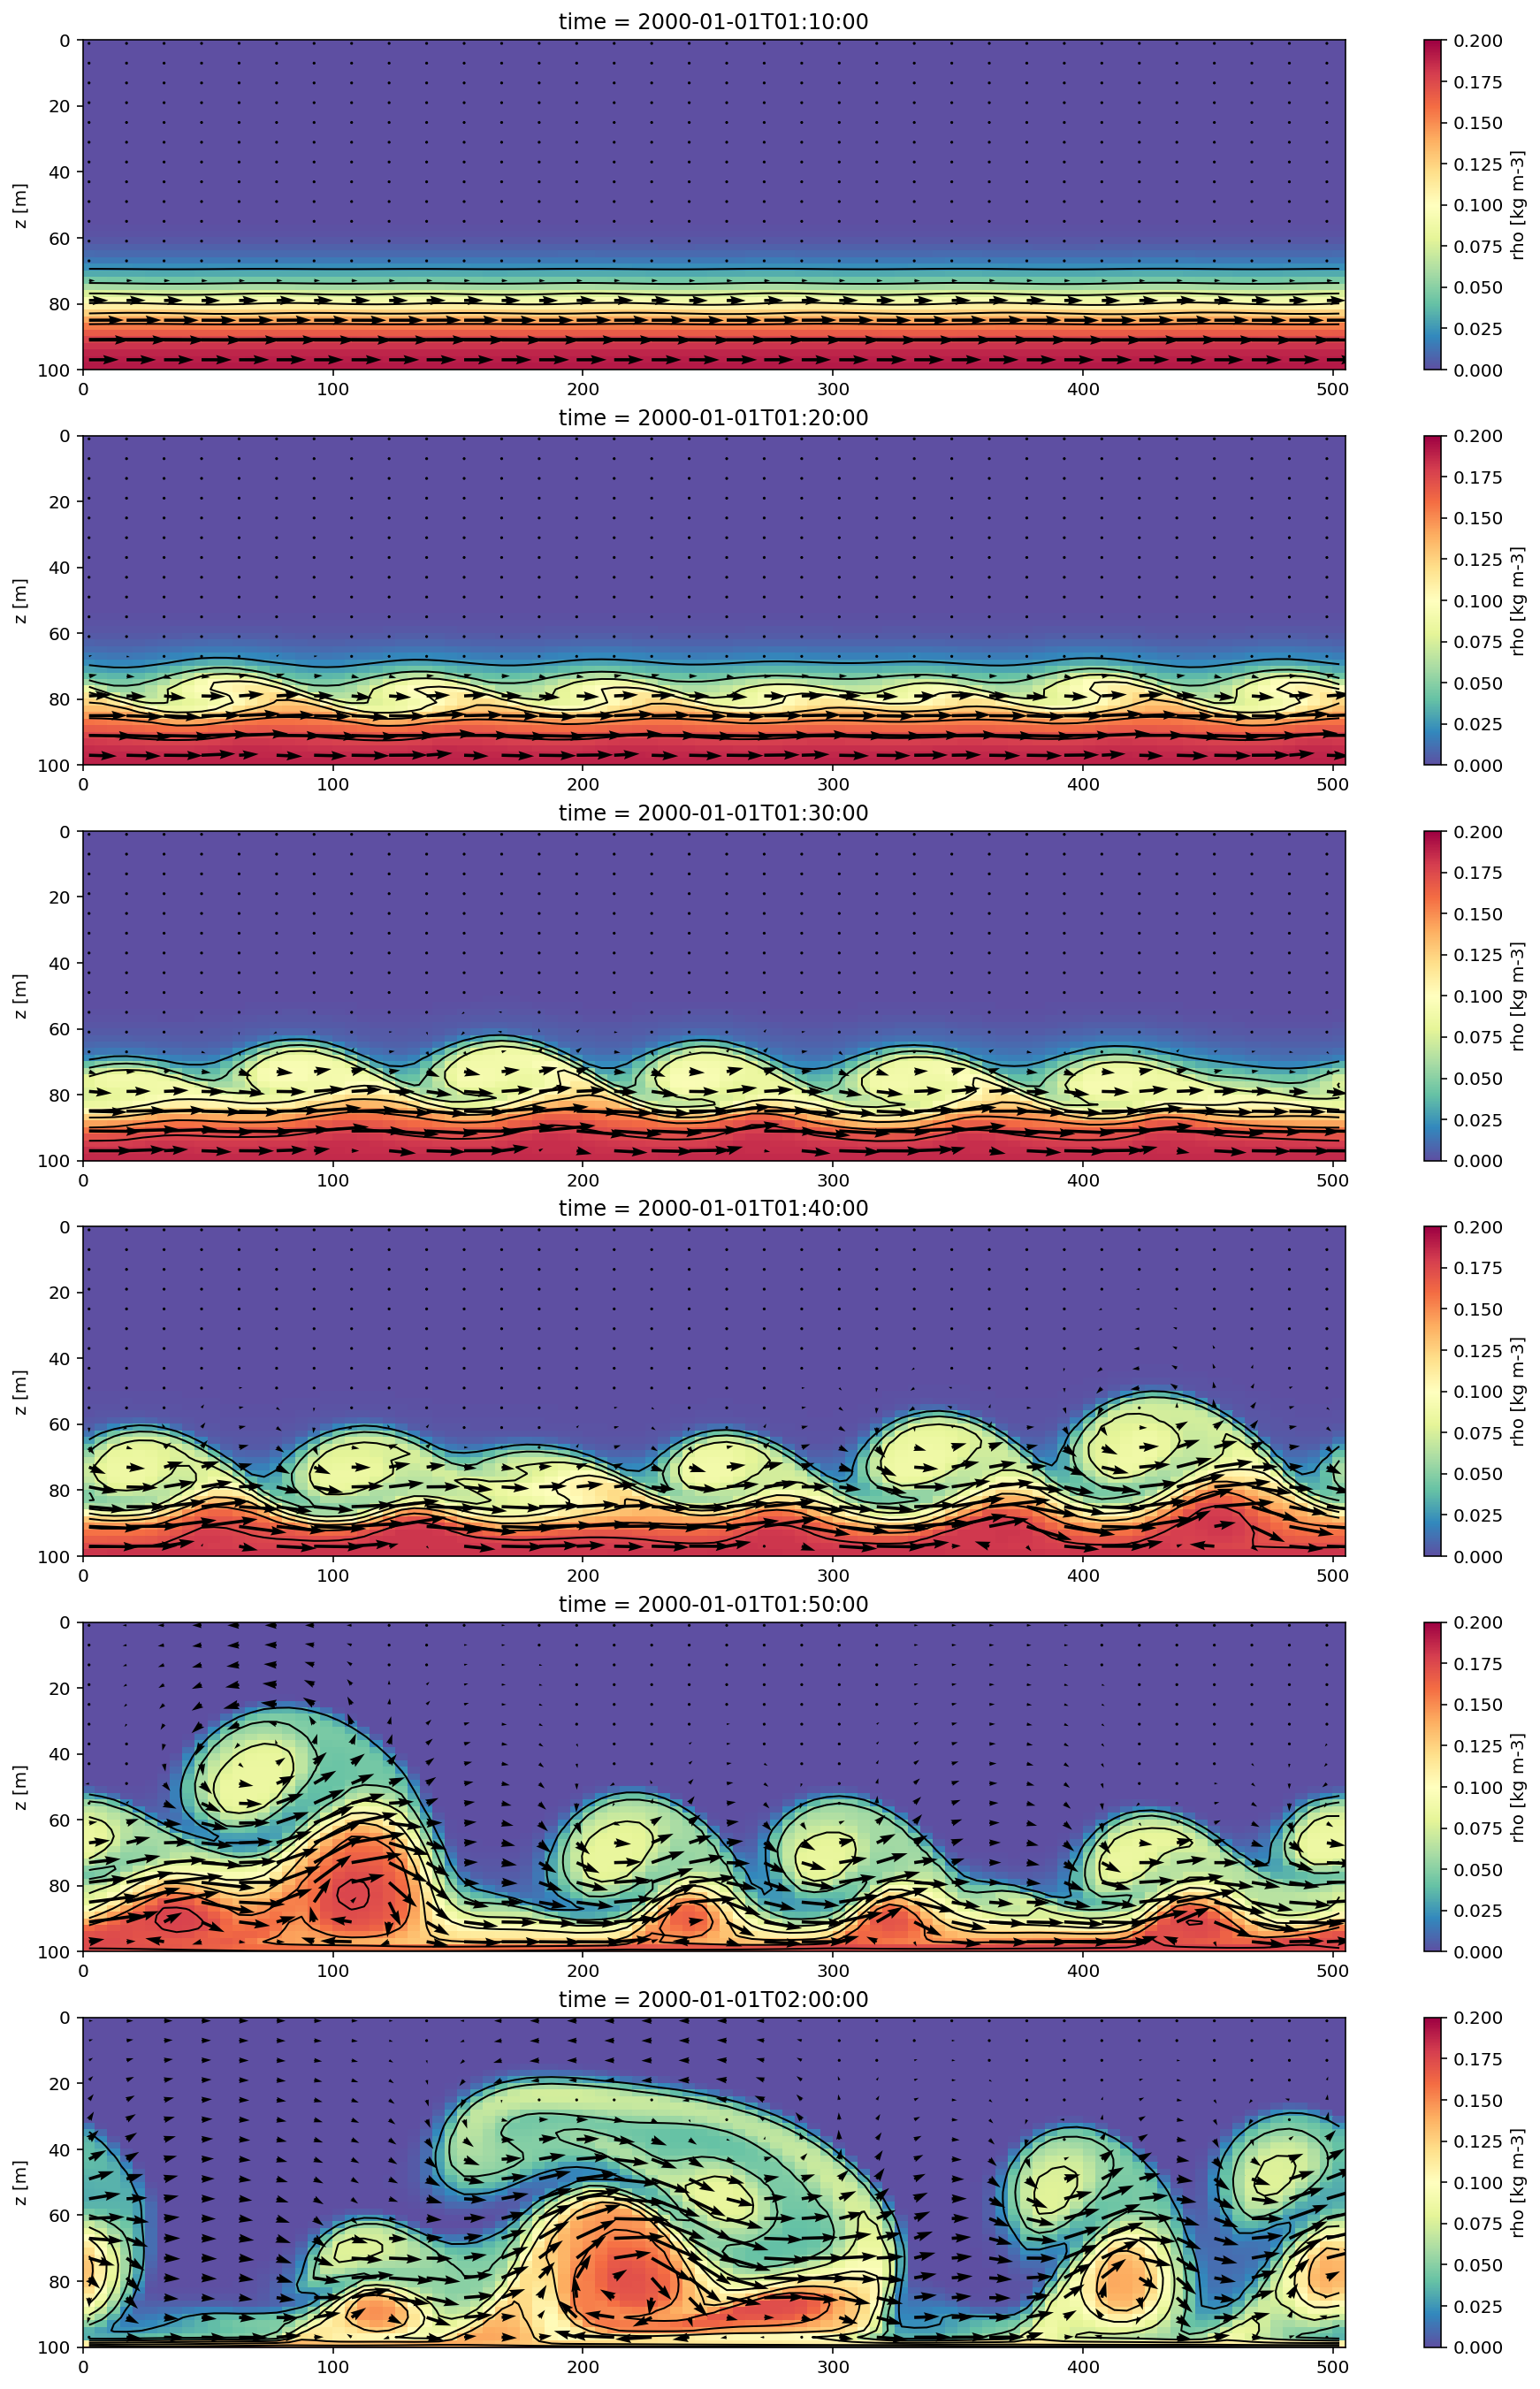

In [106]:
filename = 'src/AOM_Ex13/output.nc'
ds = xr.open_dataset(filename)

n = 6
fig, axes = plt.subplots(n, 1, figsize=(16, 24))
t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'm')

for i in range(n):
    ax = axes[i]
    p = 10*i+70
    ds.rho[p].plot(ax=ax, x='x', cmap='Spectral_r')
    ds.rho[p].plot.contour(ax=ax, x='x', colors='k', levels=10, linewidths=1)

    x, z = np.meshgrid(ds.x, ds.z)
    ax.quiver(x[::3,::3], z[::3,::3], ds.u[p].T[::3,::3],ds.w[p].T[::3,::3], scale=20)
    ax.set_xlabel('')
    ax.set_ylim(100, 0)

### Axis transforms

Cosider the following plot of a rectangle

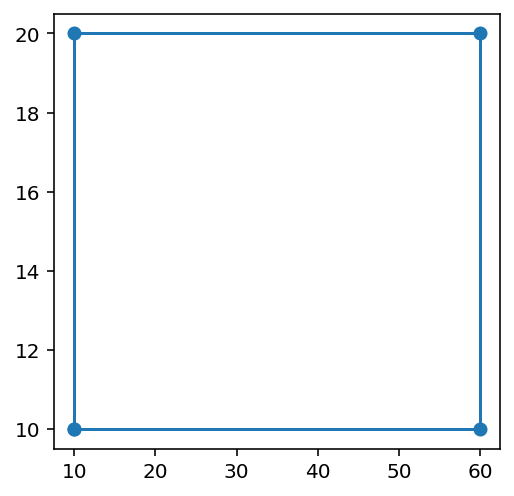

In [341]:
data_x = [10, 10, 60, 60, 10]
data_y = [10, 20, 20, 10, 10]

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(data_x, data_y, 'o-')

plt.show()

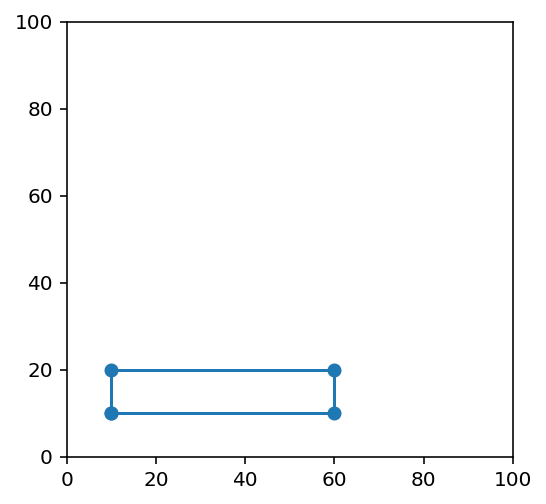

In [342]:
data_x = [10, 10, 60, 60, 10]
data_y = [10, 20, 20, 10, 10]

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(data_x, data_y, 'o-')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.show()

You can use the ax.transData instance to transform from your data to your display coordinate system, either a single point or a sequence of points as shown below:

In [343]:
type(ax.transData)

matplotlib.transforms.CompositeGenericTransform

In [344]:
ax.transData.transform((60, 20))

array([169.92 ,  79.488])

You can use the `inverted()` method to create a transform which will take you from display to data coordinates:

In [345]:
inv = ax.transData.inverted()
inv.transform([169.92, 79.488])

array([60., 20.])

In general, these 2D transformation can be represented as matrices:

In [346]:
ax.transData.get_matrix()

array([[ 2.232 ,  0.    , 36.    ],
       [ 0.    ,  2.1744, 36.    ],
       [ 0.    ,  0.    ,  1.    ]])

See https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation for examples

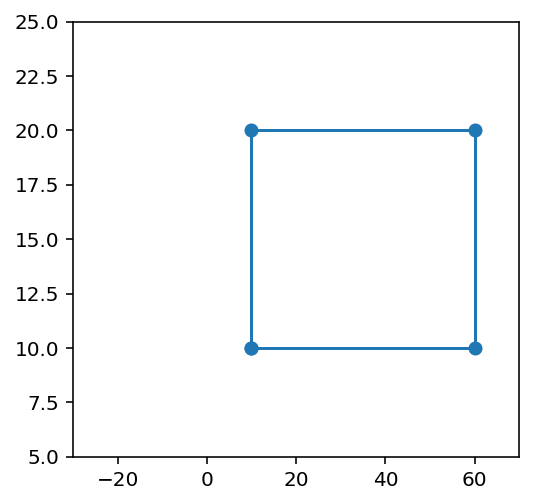

In [347]:
data_x = [10, 10, 60, 60, 10]
data_y = [10, 20, 20, 10, 10]

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(data_x, data_y, 'o-')
ax.set_xlim(-30, 70)
ax.set_ylim(5, 25)

plt.show()

In [348]:
ax.transData.get_matrix()

array([[  2.232,   0.   , 102.96 ],
       [  0.   ,  10.872, -18.36 ],
       [  0.   ,   0.   ,   1.   ]])

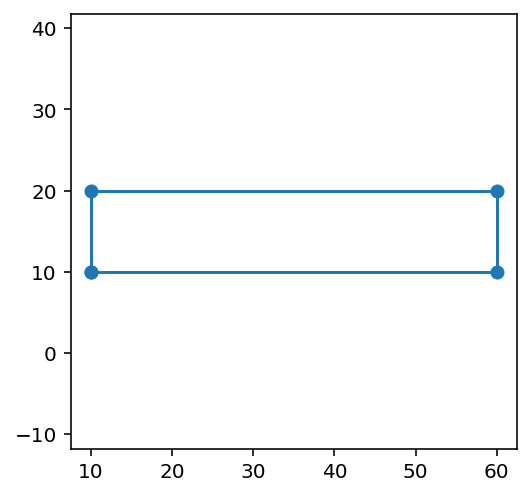

In [349]:
data_x = [10, 10, 60, 60, 10]
data_y = [10, 20, 20, 10, 10]

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(data_x, data_y, 'o-')
plt.axis('equal')

plt.show()

In [350]:
ax.transData.get_matrix()

array([[ 4.05818182,  0.        ,  5.56363636],
       [ 0.        ,  4.05818182, 83.84727273],
       [ 0.        ,  0.        ,  1.        ]])

Notice the scaling factors are now exactly the same!

In [355]:
from matplotlib import transforms

In [356]:
trans = transforms.Affine2D() # a mutable transform
trans.get_matrix()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [357]:
trans = transforms.Affine2D()
trans.translate(30, 20)
trans.get_matrix()

array([[ 1.,  0., 30.],
       [ 0.,  1., 20.],
       [ 0.,  0.,  1.]])

In [358]:
trans = transforms.Affine2D()
trans.rotate_deg(45)
trans.get_matrix()

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

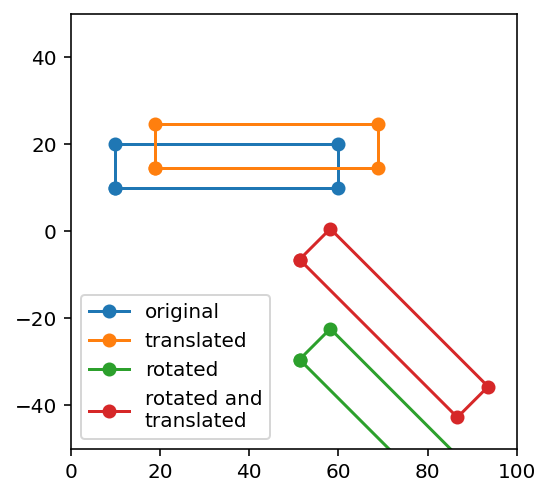

In [359]:
data_x = [10, 10, 60, 60, 10]
data_y = [10, 20, 20, 10, 10]

fig, ax = plt.subplots(figsize=(4, 4))

base = ax.transData
ax.set_xlim(0, 100)
ax.set_ylim(-50, 50)

ax.plot(data_x, data_y, 'o-', transform=base, label='original')

transform1 = transforms.Affine2D()
transform1.translate(40, 20)
ax.plot(data_x, data_y, 'o-', transform=base + transform1, label='translated')

transform2 = transforms.Affine2D()
transform2.rotate_deg(-45)
ax.plot(data_x, data_y, 'o-', transform=base + transform2, label='rotated')

transform3 = transforms.Affine2D()
transform3.rotate_deg(-45)
transform3.translate(0, 100)
ax.plot(data_x, data_y, 'o-', transform=base + transform3, label='rotated and\ntranslated')

plt.legend()

plt.show()

For additional information see https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html  

Internally, this is how graphics packages like Matplotlib handle zoom, panning, log scales, and different projections:  e.g. https://matplotlib.org/stable/gallery/misc/custom_projection.html

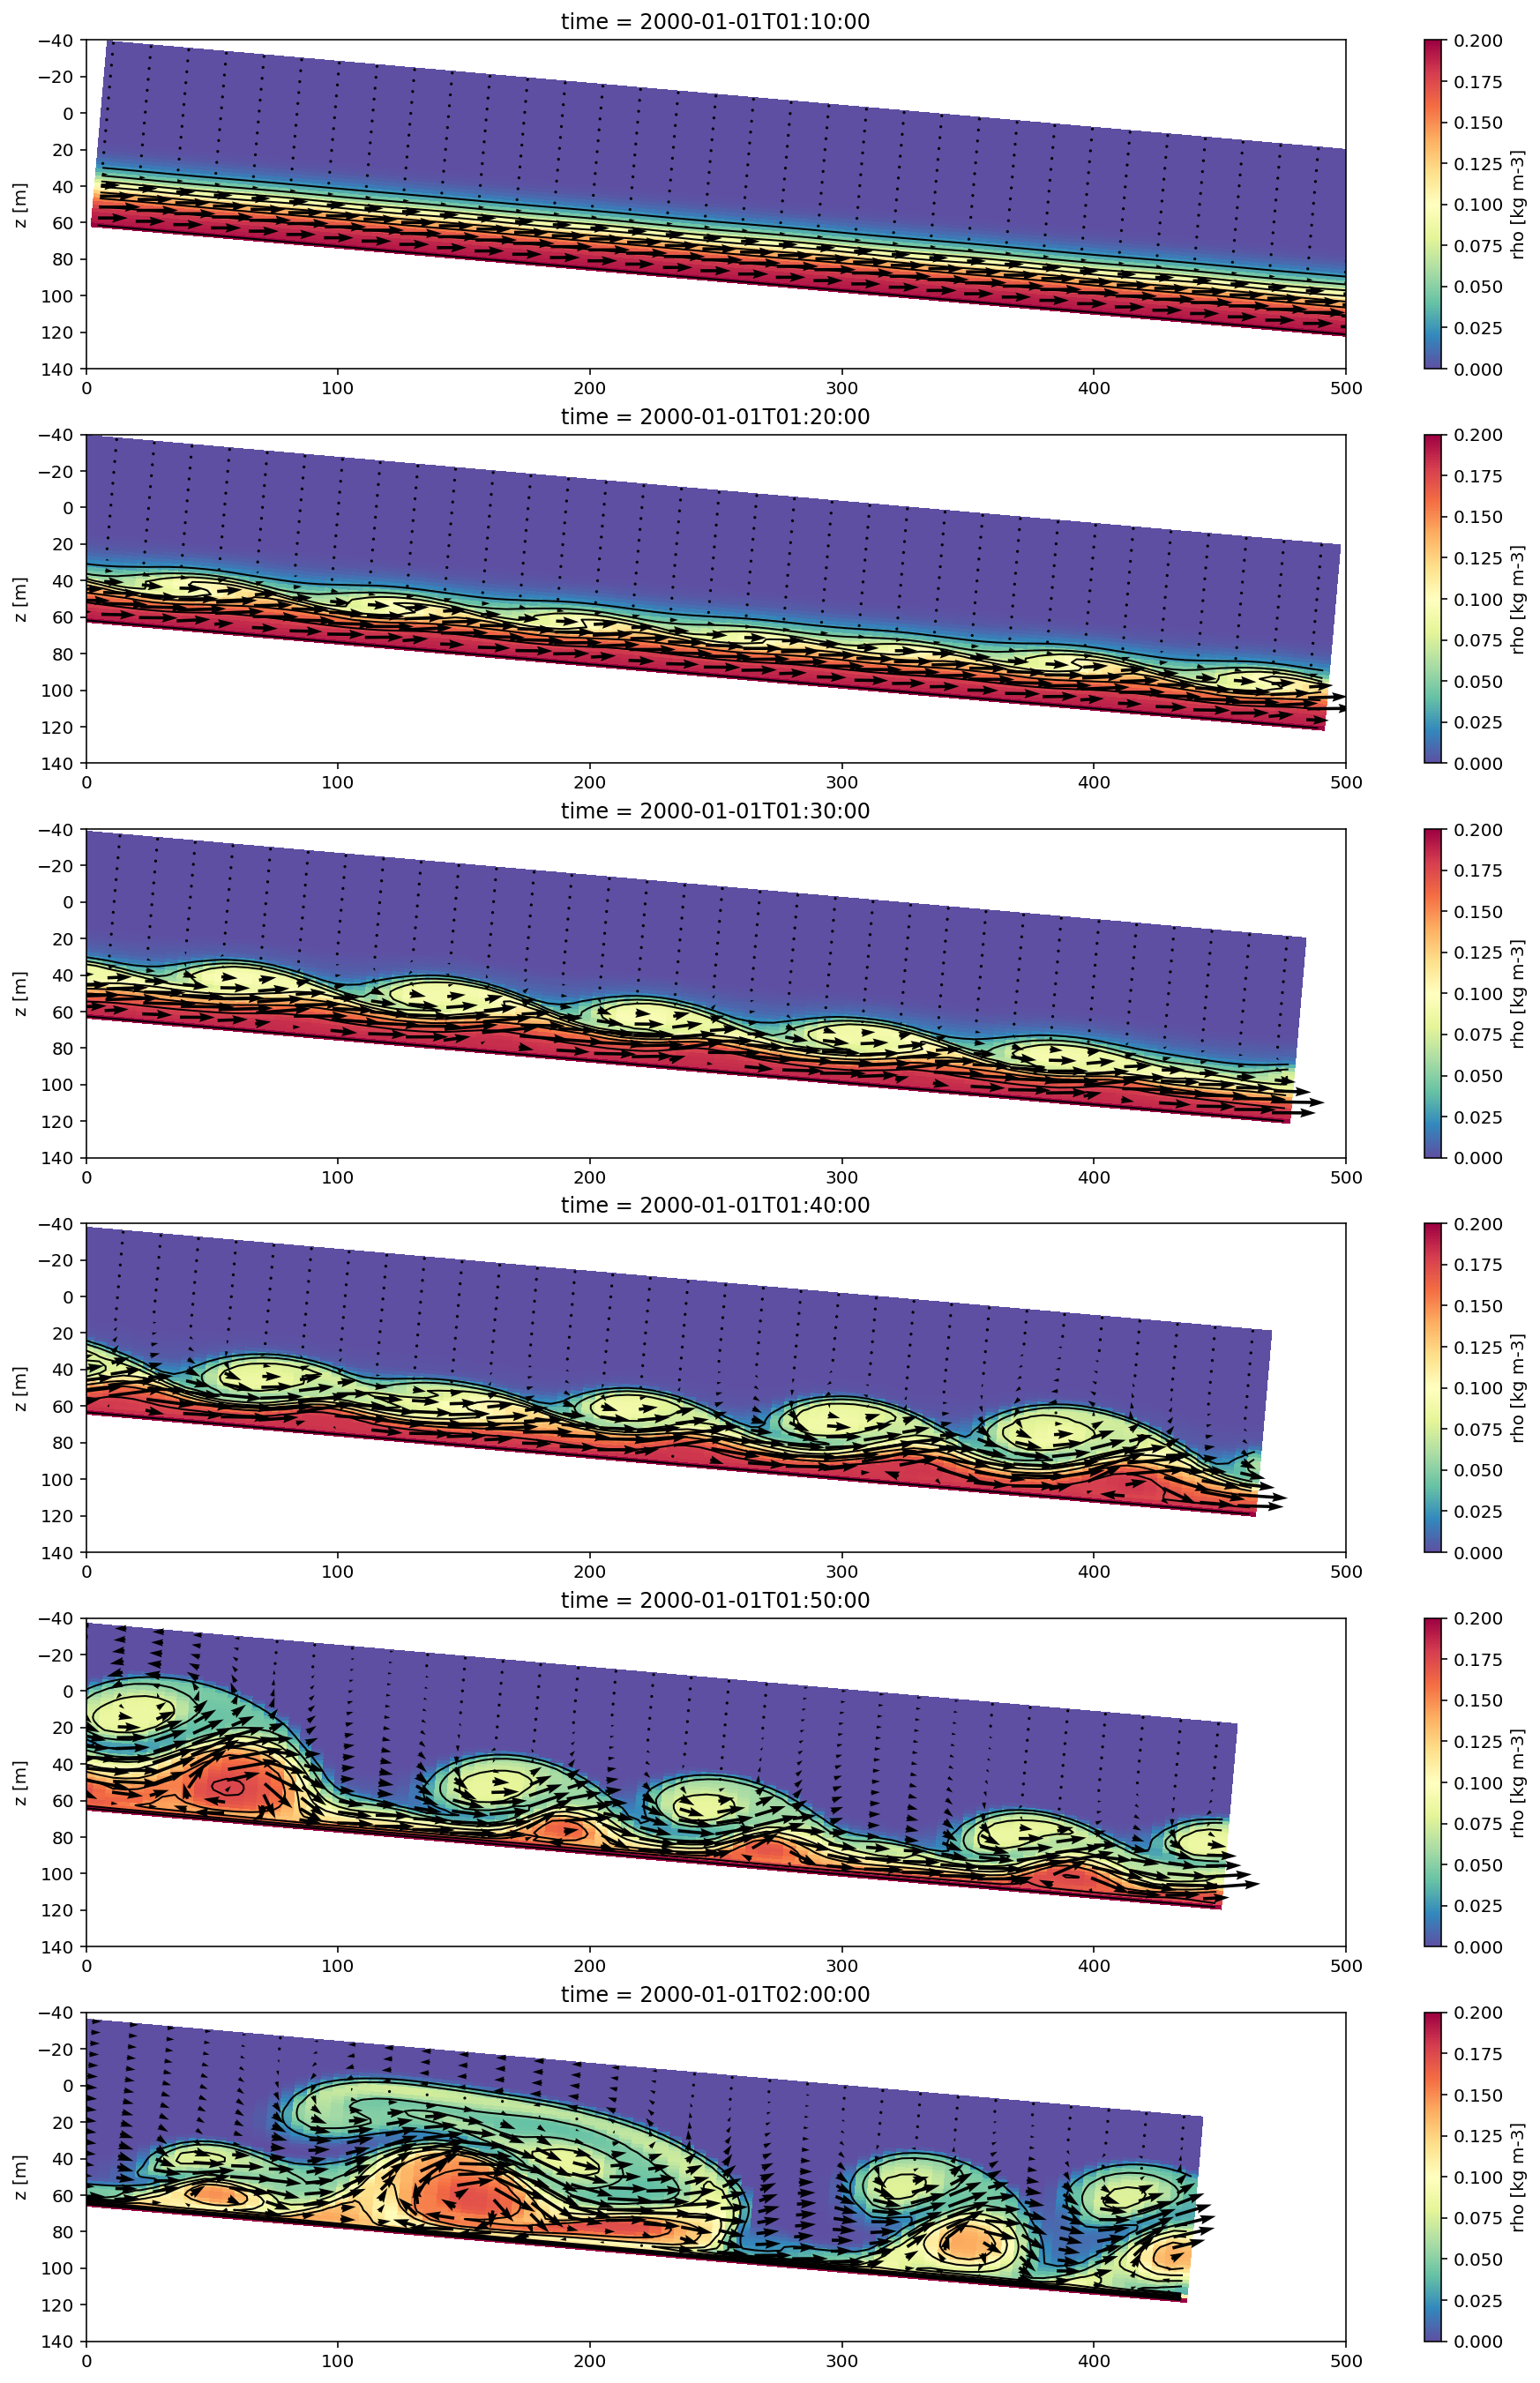

In [363]:
from matplotlib import transforms

filename = 'src/AOM_Ex13/output.nc'
ds = xr.open_dataset(filename)

n = 6
fig, axes = plt.subplots(n, 1, figsize=(16, 24))
t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'm')

for i in range(n):
    ax = axes[i]
    
    base = ax.transData
    transform = transforms.Affine2D()
    transform.rotate_deg(-5)
    transform.translate(-200,100)

    p = 10*i+70
    ds.rho[p].plot(ax=ax, x='x', cmap='Spectral_r', transform=base+transform)
    ds.rho[p].plot.contour(ax=ax, x='x', colors='k', levels=10, linewidths=1, transform=base+transform)

    x, z = np.meshgrid(ds.x, ds.z)
    ax.quiver(x[::3,::3], z[::3,::3], ds.u[p].T[::3,::3],ds.w[p].T[::3,::3], scale=20, transform=base+transform)
    ax.set_xlabel('')
    
    ax.set_ylim(140, -40)
    ax.set_xlim(0, 500)
    